## <font style="font-family:roboto;color:#455e6c"> Concentration Dependent Stress-Strain Simulation DAMASK </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> StahlDigital Tutorial: Creating and Running Simulations for Steel Development </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 25 April 2024 </font>
</div>

In this notebook, we will use `pyiron`:
- to relax a base crystal structure with `Lammps`.
- to create `special quasirandom structures (sqs)` with requested chemical composition from the base crystal structure with.
- to calculate elastic tensors of the sqs structures with different chemical comosition.
- to calculate concentration depandent stress-strain curves with `Damask` using the calculated elastic tensors.

### <font style="font-family:roboto;color:#455e6c"> Import necessary libraries </font>  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from pyiron import Project
import seaborn as sns

In [2]:
from damask import Rotation # We need this to create rotation

In [3]:
# Unit conversion factors: from megapascal(MPa) and gegapascal(GPa) to pascal(Pa)  
MPa_to_Pa = 1e+6
GPa_to_Pa = 1e+9

#### <font style="font-family:roboto;color:#455e6c"> Create a pyiron project </font>  

In [4]:
pr = Project('lammps_damask_workflow_test0')

#### <font style="font-family:roboto;color:#455e6c"> Minimize the base structure </font>  

Our base structure is bcc Fe with 0% Al

In [32]:
# Structure optimization with Lammps
lmp_mini = pr.create.job.Lammps(job_name='lammps_mini')
lmp_mini.structure = pr.create.structure.bulk('Fe', cubic=True).repeat(10)
lmp_mini.potential = '2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1'
lmp_mini.calc_minimize(pressure=0.0)
lmp_mini.run()

The job lammps_mini was saved and received the ID: 143


#### <font style="font-family:roboto;color:#455e6c"> Create the SQS structures </font> 

We will create `SQS` structures for four dilute concentrations of `Al (1%, 2%, 3%, and 4%)`

In [33]:
concentrations = [0.0, 0.01, 0.02, 0.03, 0.04]

In [34]:
sqs_job = pr.create.job.SQSJob(job_name="sqs_job_al")
sqs_job.structure = lmp_mini.get_structure()
sqs_job.input['iterations'] = 2000

sqs_master_job = pr.create.job.SQSMaster(job_name="master_al")
sqs_master_job.ref_job = sqs_job
sqs_master_job.input["fraction_lst"] = concentrations[1:]
sqs_master_job.input["species_one"] = "Al"
sqs_master_job.input["species_two"] = "Fe"
sqs_master_job.run()

The job master_al was saved and received the ID: 144
The job sqs_0_01 was saved and received the ID: 145
The job sqs_0_02 was saved and received the ID: 146
The job sqs_0_03 was saved and received the ID: 147
The job sqs_0_04 was saved and received the ID: 148


Collect all structures, including the base structure without any Alluminum

In [35]:
# Collect all structures into a list
structure_lst = [lmp_mini.get_structure()] + sqs_master_job.list_of_structures

In [36]:
# Print chemical formula of each structures
[s.get_chemical_formula() for s in structure_lst]

['Fe2000', 'Al20Fe1980', 'Al40Fe1960', 'Al60Fe1940', 'Al80Fe1920']

#### <font style="font-family:roboto;color:#455e6c"> Calculate elastic tensors for all structures </font> 

In [37]:
# Elastic tensor calculation
for s in structure_lst:
    lmp_template = pr.create.job.Lammps('lammps_tmp')
    lmp_template.potential = '2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1'
    lmp_template.server.run_mode.interactive = True
    lmp_template.interactive_enforce_structure_reset = True
    lmp_template.structure = s
    elastic = lmp_template.create_job(pr.job_type.ElasticTensor, 
                                      'elastic_' + s.get_chemical_formula())
    elastic.input['num_of_points'] = 5
    elastic.input['fit_order'] = 2
    elastic.input['eps_range'] = 0.005
    elastic.input['relax_atoms'] = True
    elastic.input['sqrt_eta'] = True
    elastic.run()

The job elastic_Fe2000 was saved and received the ID: 149
The job elastic_Fe2000_lammps_tmp was saved and received the ID: 150


/home/usaikia/apps/miniforge3/envs/damask_env/lib/python3.11/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al20Fe1980 was saved and received the ID: 151
The job elastic_Al20Fe1980_lammps_tmp was saved and received the ID: 152


/home/usaikia/apps/miniforge3/envs/damask_env/lib/python3.11/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al40Fe1960 was saved and received the ID: 153
The job elastic_Al40Fe1960_lammps_tmp was saved and received the ID: 154


/home/usaikia/apps/miniforge3/envs/damask_env/lib/python3.11/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al60Fe1940 was saved and received the ID: 155
The job elastic_Al60Fe1940_lammps_tmp was saved and received the ID: 156


/home/usaikia/apps/miniforge3/envs/damask_env/lib/python3.11/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al80Fe1920 was saved and received the ID: 157
The job elastic_Al80Fe1920_lammps_tmp was saved and received the ID: 158


/home/usaikia/apps/miniforge3/envs/damask_env/lib/python3.11/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


#### <font style="font-family:roboto;color:#455e6c"> Collect elastic tensor values for all structures using PyironTable Job </font> 

In [38]:
# Define some python function to collect the data from our project
def filter_function(job): 
    return "elastic_" in job.job_name and "lammps_tmp" not in job.job_name
    
def get_c11(job):
    return job["output/elastic_tensor"][0,0]

def get_c12(job):
    return job["output/elastic_tensor"][0,1]

def get_c44(job):
    return job["output/elastic_tensor"][3,3]

In [39]:
# Create and run the Pyiron Table Job
table = pr.create_table()

table.filter_function = filter_function
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

table.run()

The job table was saved and received the ID: 159


Loading and filtering jobs:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
# Convert the collected data into a pandas DataFrame
df_data = table.get_dataframe()
df_data

,job_id,C11,C12,C44
0,149,240.204251,143.733002,113.178921
1,151,238.047815,143.068198,113.843195
2,153,235.905470,143.126675,113.215290
3,155,234.085362,143.078658,114.155148
4,157,231.595639,143.078412,115.254347


#### <font style="font-family:roboto;color:#455e6c"> Continuous concentration using ploynomial fitting </font> 

In [41]:
# Collect the required elastic constant values from pndas DataFrame
C11_data = df_data["C11"].values
C12_data = df_data["C12"].values
C44_data = df_data["C44"].values

In [42]:
# Second order ploynomial fitting of the elastic constants 
fit_degree = 2
C11_fit = np.polyfit(concentrations, C11_data, deg=fit_degree)
C12_fit = np.polyfit(concentrations, C12_data, deg=fit_degree)
C44_fit = np.polyfit(concentrations, C44_data, deg=fit_degree)
c = np.linspace(min(concentrations),
                max(concentrations), 100) # Continuous concentration

In [43]:
%matplotlib inline

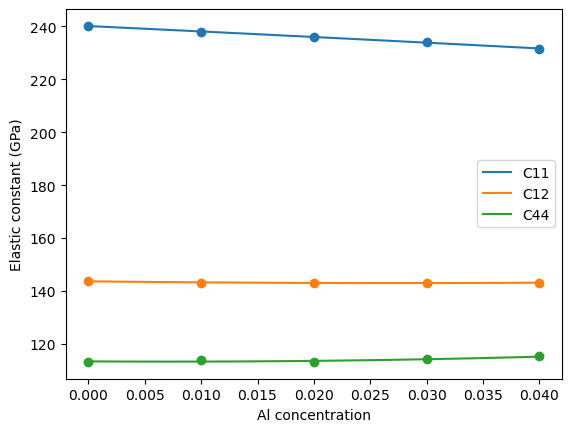

In [44]:
# Plot the original and fitted elastic constant values
for color, data, fit, label in zip(
    sns.color_palette(n_colors=3), 
    [C11_data, C12_data, C44_data], 
    [C11_fit, C12_fit, C44_fit],
    ['C11', 'C12', 'C44']
):
    plt.scatter(concentrations, data, color=color)
    plt.plot(c, np.polyval(fit, c), color=color, label=label)
plt.xlabel('Al concentration')
plt.ylabel('Elastic constant (GPa)')
plt.legend()
plt.show();

#### <font style="font-family:roboto;color:#455e6c"> Run DAMASK simulation usnig the fitted elastic constant values </font> 

In [45]:
# A python function to run DAMASK
def run_damask_simulation(elasticity_data, 
                          plasticity_data,
                          delete_existing_job=False):
    """
    This function takes elastic tensors as input argument and returns
    strain and stress values of damask tensile simulation.
    """
    # Create a damask job
    job_damask = pr.create.job.DAMASK("damask_simulation_"+str(c), 
                                      delete_existing_job=delete_existing_job)
    
    # Elastic paramaters of the material
    elasticity = pr.continuum.damask.Elasticity(**elasticity_data)
    
    # Plastic parameters of the material
    plasticity = pr.continuum.damask.Plasticity(**plasticity_data)
    # Define phase of the material
    phase = pr.continuum.damask.Phase(composition ='DX56D',
                                      lattice = 'cI',
                                      output_list = ['F', 'P'],
                                      elasticity = elasticity, 
                                      plasticity = plasticity
                                     )
    # Define homogenization
    homogenization = pr.continuum.damask.Homogenization(method='SX',
                                                        parameters={'N_constituents': 1,
                                                                    "mechanical": {"type": "pass"}})
    # Defines the number of grains and grids
    grains = 60
    grids = 16 
    
    # Define homogenization
    rotation = pr.continuum.damask.Rotation(Rotation.from_random,
                                            grains)
    # Materialpoint configuration
    material = pr.continuum.damask.Material([rotation],
                                            ['DX56D'],
                                            phase,
                                            homogenization)
    # Define grid
    grid = pr.continuum.damask.Grid.via_voronoi_tessellation(spatial_discretization=grids,
                                                             num_grains=grains,
                                                             box_size=1.6e-5)
    
    # Assign the material and grid to the damask job
    job_damask.material = material
    job_damask.grid = grid
    
    # Generate a load case for the grid solver
    load_step =[{'mech_bc_dict' : 
                 {'dot_F' : [1e-3, 0, 0,
                             0, 'x', 0,
                             0, 0, 'x'],
                  'P' : ['x', 'x', 'x',
                         'x', 0, 'x',
                         'x', 'x', 0]
                  },
                 'discretization' : {'t' : 10., 'N' : 40},
                 'additional': {'f_out' : 4}
                 },
                {'mech_bc_dict' : 
                 {'dot_F' : [1e-3, 0, 0,
                             0, 'x', 0,
                             0, 0, 'x'],
                  'P':['x', 'x', 'x',
                       'x', 0, 'x',
                       'x', 'x', 0]
                 },
                 'discretization' : {'t' : 50., 'N' : 50}, # Use t=250. and N=250
                 'additional': {'f_out' : 4}
                 }]
    
    # Assign solver and load step to the damask job
    job_damask.loading = pr.continuum.damask.Loading(solver=job_damask.list_solvers()[0],
                                                     load_steps=load_step
                                                     )
    # Run the simulation
    job_damask.run()

    return job_damask.output.strain_von_Mises, job_damask.output.stress_von_Mises

In [46]:
# Set plasticity parameters of the material
plasticity_data = {"type": "phenopowerlaw",
                   "references": ["https://doi.org/10.1016/j.actamat.2014.07.071",
                                   "https://doi.org/10.1007/BF02900224"],
                   "output": ["xi_sl", "gamma_sl"],
                   "N_sl": [12, 12],
                   "dot_gamma_0_sl": [0.001, 0.001],
                   "n_sl": [20, 20],
                   "a_sl": [3.3838750211834414, 2.71513775941709],
                   "xi_0_sl": [58854884.55400854, 116398683.46869445],
                   "xi_inf_sl": [245397260.8849832, 289183253.8512693],
                   "h_0_sl_sl": [839702224.3104236, 797832430.2007155],
                   "h_sl_sl": [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4, 1.4,
                                1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
                                1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
                   }

In [47]:
# Run damask simulation for three concentrations [0.0, 0.02, 004]
result = []
for i, c in enumerate(concentrations[::2]):
    print("Running for concentrations:", c)
    elasticity_data = {"type": "Hooke",
                       "C_11":float(np.polyval(C11_fit, c))*GPa_to_Pa,
                       "C_12":float(np.polyval(C12_fit, c))*GPa_to_Pa,
                       "C_44":float(np.polyval(C44_fit, c))*GPa_to_Pa
                      }
    
    result.append(run_damask_simulation(elasticity_data,
                                        plasticity_data,
                                       delete_existing_job=True)
                 )
np.save("lammps_damask_workflow_test0.npy", result)

Running for concentrations: 0.0
The job damask_simulation_0d0 was saved and received the ID: 160
Running for concentrations: 0.02
The job damask_simulation_0d02 was saved and received the ID: 161
Running for concentrations: 0.04
The job damask_simulation_0d04 was saved and received the ID: 162


In [6]:
result = np.load("lammps_damask_workflow_test0.npy")

#### <font style="font-family:roboto;color:#455e6c"> Plot damask calculated stress-strain curves for different concentrations </font>

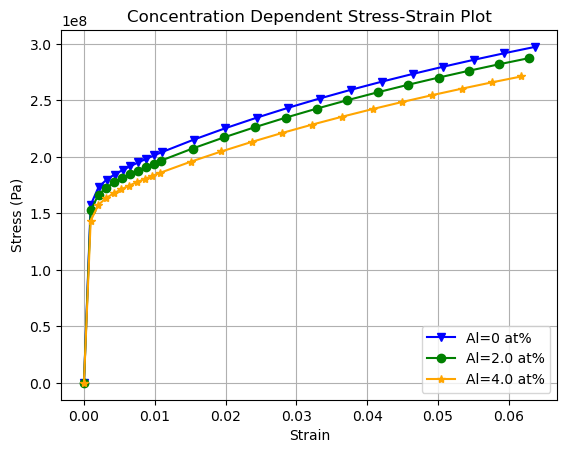

In [37]:
# Plot the result
colors = ['r','g','b']
plt.plot(result[0][0], result[0][1], 'blue', marker = 'v' ,
         label = 'Al={} at%'.format(0*100))
plt.plot(result[1][0], result[1][1], 'green', linestyle="-",marker = 'o' ,
         label = 'Al={} at%'.format(0.02*100))
plt.plot(result[2][0], result[2][1], 'orange', linestyle="-",marker = '*' ,
         label = 'Al={} at%'.format(0.04*100))
plt.grid(True)
plt.xlabel('Strain')
plt.ylabel('Stress (Pa)')
plt.legend( loc='lower right')
plt.title("Concentration Dependent Stress-Strain Plot")
plt.savefig("FeAl_tensile_simulation.png", dpi=600)
plt.show();

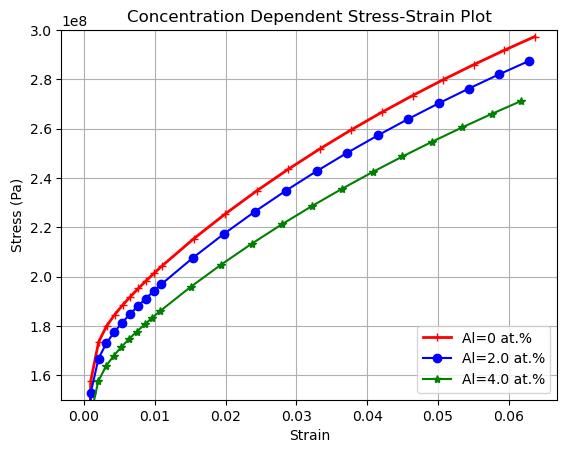

In [34]:
# Plot the result
colors = ['r','g','b']
plt.plot(result[0][0], result[0][1], 'r', linewidth=2,marker = '+' ,
         label = 'Al={} at.%'.format(0*100))
plt.plot(result[1][0], result[1][1], 'b', linestyle="-",marker = 'o' ,
         label = 'Al={} at.%'.format(0.02*100))
plt.plot(result[2][0], result[2][1], 'g', linestyle="-",marker = '*' ,
         label = 'Al={} at.%'.format(0.04*100))
plt.grid(True)
plt.xlabel('Strain')
plt.ylabel('Stress (Pa)')
plt.legend( loc='lower right')
plt.title("Concentration Dependent Stress-Strain Plot")
plt.ylim(1.5e8,3.0e8)
plt.show();